In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pymc as pm
import arviz as az
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, RidgeCV
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler

#### CONTROL CELL ####

In [2]:
# INITIAL FORECAST

# 1. Define dataset range for modeling (training + validation)
start_date = pd.to_datetime('2007-01-01') #######################################################################################################
end_date = pd.to_datetime('2025-03-01') #########################################################################################################

# MODEL VARIABLES
vars_yoy = []
ind = ['grocery_sales_lag1', 'cpi_fah', 'rdi_adj', 'home_price', 'covid1', 'covid2']
dep = 'grocery_sales'
dep_label = "Grocery Sales"
ind_0 = 'grocery_sales_lag1' 
ind_1 = 'cpi_fah'
ind_2 = 'rdi_adj'
ind_3 = 'home_price'
ind_4 = 'covid1'
ind_5 = 'covid2'

# Define all variables you want to pull from sales_coef
coef_names = ['const', 'grocery_sales_lag1', 'cpi_fah', 'rdi_adj', 'home_price', 'covid1', 'covid2']

#--------------------------------------------
#FORWARD FORECAST PREP

#Set the forward forecast dates
forward_start_date = end_date + pd.DateOffset(months=1)
forward_end_date = forward_start_date + pd.DateOffset(months=5)

# Build datetime-based forecast index
forecast_months = pd.date_range(start=forward_start_date, end=forward_end_date, freq='MS')

# Create empty forecast frame
forward_df = pd.DataFrame(index=forecast_months)

###########################################################################################################################################################
from grocery_sales_input_202504 import (
    ind_label_1_dic,
    ind_label_2_dic,
    ind_label_3_dic,
    ind_label_4_dic,
    ind_label_5_dic
)

# Dictionary mapping each independent variable to its forecast dictionary
ind_forecast_dic = {
#    'grocery_sales_lag1': ind_label_0_dic,
    'cpi_fah': ind_label_1_dic,
    'rdi_adj': ind_label_2_dic,
    'home_price': ind_label_3_dic,
    'covid1': ind_label_4_dic,
    'covid2': ind_label_5_dic
}

#### IMPORT DATA AND ESTABLISH START AND END DATES ####

In [3]:
# Create the foundational dataset
df_ = pd.read_csv('grocery_eda_dataset.csv')
df_['date'] = pd.to_datetime(df_['date'], format='%Y-%m-%d')
df_ = df_.reset_index().set_index('date').drop(columns = 'index')
df = df_[(df_.index >= start_date) & (df_.index <= end_date)].copy()

# Pull in the forecast csv
df_fcst_chart = pd.read_csv('grocery_forecast_chart.csv')
df_fcst_chart = df_fcst_chart.rename(columns={'Unnamed: 0':'month'})
df_fcst_chart.set_index(df_fcst_chart.columns[0], inplace=True)
df_fcst_chart = df_fcst_chart['gsf_2025_02'] 

#### CHECK FOR MISSING VALUES ####

In [4]:
# Count total missing values per column
missing_counts = df.isna().sum()

# Show only columns with missing values
missing_counts = missing_counts[missing_counts > 0]

missing_counts

cons_exp_yoy        12
wages_retail_yoy     2
dtype: int64

#### BUILD THE TIME SERIES MODEL AND MERGE WITHIN SAMPLE BACK TO DF ####

In [5]:
# Define independent (X) and dependent (y) variables
X = df[ind]
y = df[dep]

# Add a constant for intercept
X = sm.add_constant(X)

# Fit OLS (Ordinary Least Squares) regression model
model = sm.OLS(y, X).fit()

# Print detailed statistical summary
print(model.summary())

# merge fitted values onto dh.  We don't need to merge because the row indices are the same
df[f'{dep}_fcst'] = model.fittedvalues
df[f'{dep}_resid'] = model.resid

print(df.index[0])
print(df.index[-1])

                            OLS Regression Results                            
Dep. Variable:          grocery_sales   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.459e+04
Date:                Fri, 25 Apr 2025   Prob (F-statistic):          2.38e-274
Time:                        16:18:33   Log-Likelihood:                -1687.4
No. Observations:                 219   AIC:                             3389.
Df Residuals:                     212   BIC:                             3412.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.147e+04   1015

#### VISUALS AND DIAGNOSTICS ####

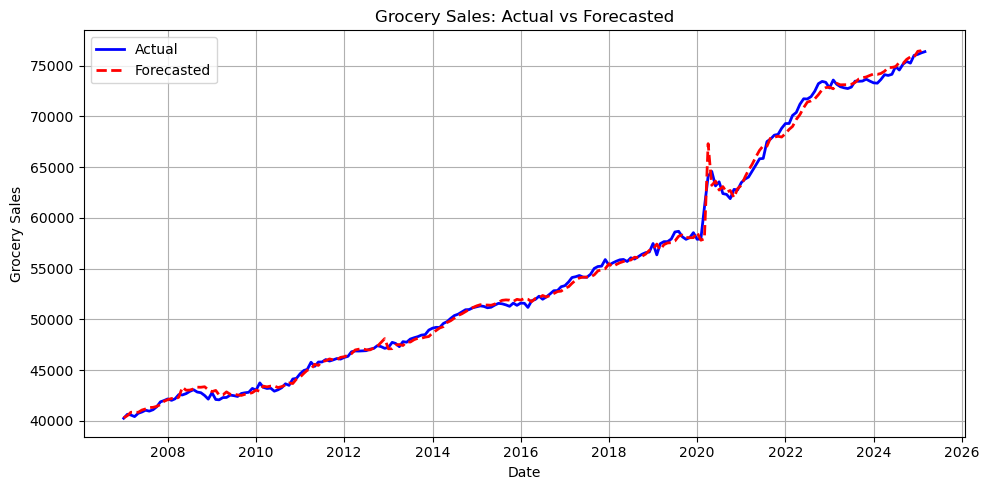

In [6]:
# Create a plotting DataFrame with datetime from yyyymm index
df_plot = df.copy()

# Plot using Seaborn
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_plot, x='date', y=dep, label='Actual', linewidth=2, color='blue')
sns.lineplot(data=df_plot, x='date', y=f'{dep}_fcst', label='Forecasted', linewidth=2, color='red', linestyle='--')

# Formatting
plt.xlabel('Date')
plt.ylabel(dep_label)
plt.title(f'{dep_label}: Actual vs Forecasted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

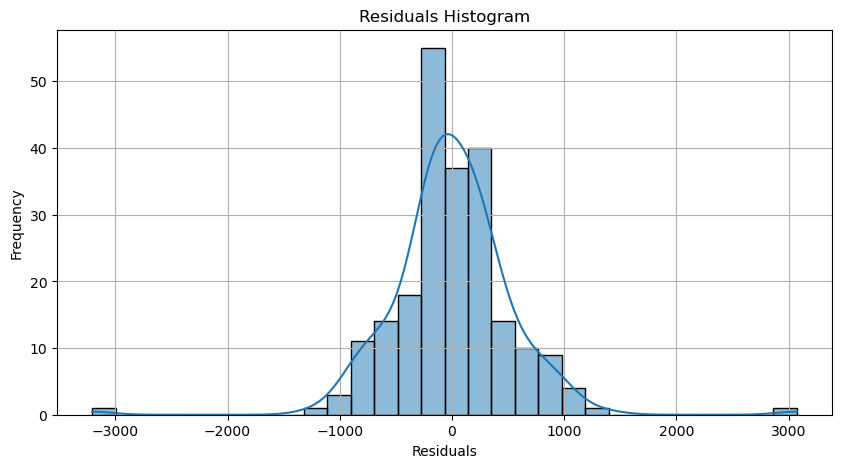

In [7]:
resid_data = df[f"{dep}_resid"].reset_index(drop=True)
plt.figure(figsize=(10, 5))
sns.histplot(resid_data, bins=30, kde=True)
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

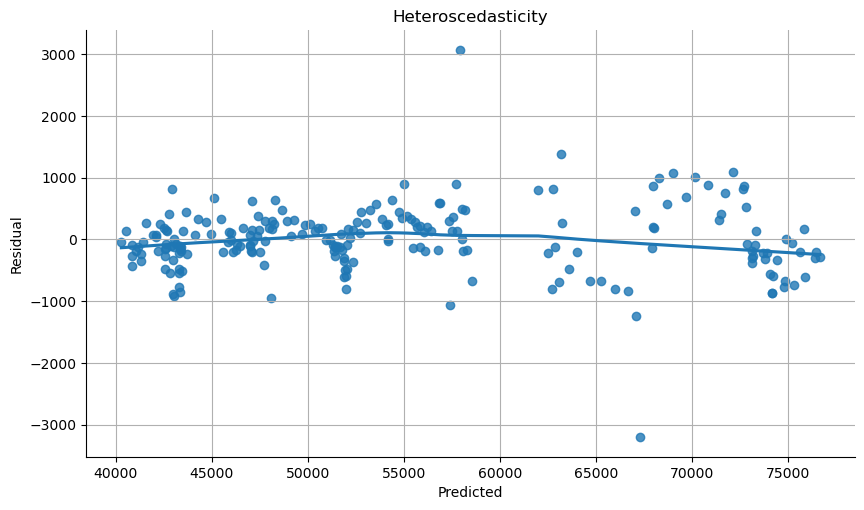

In [8]:
resid_data = df[f"{dep}_resid"].reset_index(drop=True)
# Reset both predicted and residual Series
pred_data = df[f"{dep}_fcst"].reset_index(drop=True)
resid_data = df[f"{dep}_resid"].reset_index(drop=True)

# Combine into a clean DataFrame
df_plot = pd.DataFrame({
    f"{dep}_fcst": pred_data,
    f"{dep}_resid": resid_data
})

sns.lmplot(
    x=f"{dep}_fcst", y=f"{dep}_resid",
    data=df_plot, lowess=True, aspect=1.75, height=5
)
plt.title('Heteroscedasticity')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.grid(True)
plt.show()

In [9]:
# Step 1: Add a constant column (intercept)
X = sm.add_constant(X)

# Step 2: Initialize an empty list to store VIF values
vif_list = []

# Step 3: Loop through each feature and compute VIF
for i in range(X.shape[1]):  # Loop over each column index
    vif_value = variance_inflation_factor(X.values, i)  # Compute VIF for the column
    vif_list.append((X.columns[i], vif_value))  # Store (Feature Name, VIF Value)

# Step 4: Convert results into a DataFrame
vif_data = pd.DataFrame(vif_list, columns=["Feature", "VIF"])
vif_data

,Feature,VIF
0,const,757.805564
1,grocery_sales_lag1,95.300883
2,cpi_fah,24.056671
3,rdi_adj,24.156956
4,home_price,11.270955
5,covid1,1.260706
6,covid2,1.247235


#### GET SE MEAN AND CONFIDENCE INTERVALS ####

In [10]:
# Ensure X includes the same predictors used in training

# Get predictions and confidence intervals
predictions = model.get_prediction(X)
pred_summary = predictions.summary_frame(alpha=0.05)  # 95% CI

# Store confidence intervals in df
df[f'{dep}_se_mean'] = pred_summary['mean_se']  # SE of the mean
df[f'{dep}_se_lower'] = pred_summary['mean_ci_lower']  # SE of the mean
df[f'{dep}_se_upper'] = pred_summary['mean_ci_upper']  # SE of the mean
df['lower_bound'] = pred_summary['obs_ci_lower']  # SE of the mean
df['upper_bound'] = pred_summary['obs_ci_upper']  # SE of the mean

# ✅ Compute SE of the estimate (obs_se) using the upper and lower columns 
df[f'{dep}_se_obs'] = (df['upper_bound'] - df['lower_bound']) / (2 * 1.96)  # 95% CI

# # Show first few rows
df[[f'{dep}_fcst', f'{dep}_se_mean', f'{dep}_se_obs', f'{dep}_se_lower', f'{dep}_se_upper', 
    'lower_bound', 'upper_bound']].head()

,grocery_sales_fcst,grocery_sales_se_mean,grocery_sales_se_obs,grocery_sales_se_lower,grocery_sales_se_upper,lower_bound,upper_bound
date,,,,,,,
2007-01-01,40299.069887,140.358326,566.783052,40022.393168,40575.746606,39188.175105,41409.964669
2007-02-01,40516.436099,135.095906,565.488137,40250.132750,40782.739448,39408.079350,41624.792849
2007-03-01,40845.173558,131.395758,564.605576,40586.164005,41104.183111,39738.546630,41951.800486
2007-04-01,40853.080702,130.105047,564.303163,40596.615419,41109.545985,39747.046502,41959.114902
2007-05-01,40837.255802,128.359116,563.898590,40584.232128,41090.279476,39732.014566,41942.497038


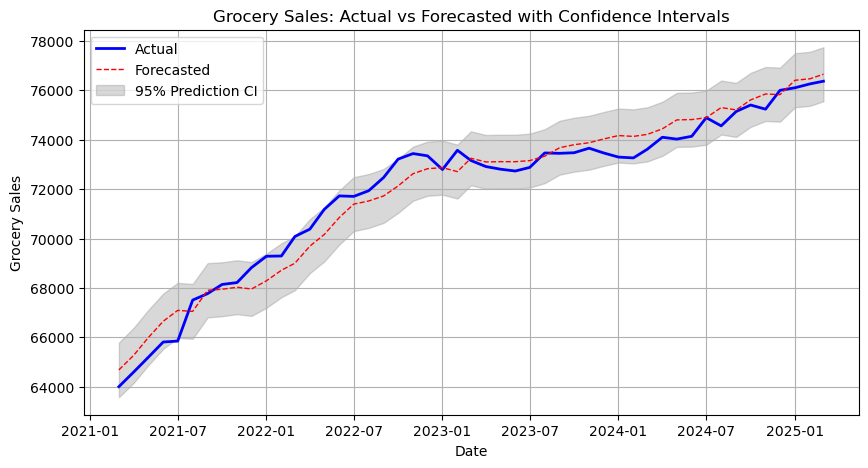

In [11]:
#Define the start and end date for filtering
end_date_chart = end_date
start_date_chart = pd.Timestamp(end_date) - pd.DateOffset(years=4) 


#Filter the DataFrame to only include the desired months
df_chart = df.loc[start_date_chart:end_date_chart]
df_chart

#Plot the chart
plt.figure(figsize=(10, 5))

sns.lineplot(data=df_chart, x=df_chart.index, y=dep, label='Actual', color='blue', linewidth=2.0)
sns.lineplot(data=df_chart, x=df_chart.index, y=f'{dep}_fcst', label='Forecasted', color='red', linewidth=1.0, linestyle='dashed')

plt.fill_between(df_chart.index, df_chart['lower_bound'], df_chart['upper_bound'], color='grey', alpha=0.3, label="95% Prediction CI")

plt.xlabel('Date')
plt.ylabel(dep_label)
plt.title(f'{dep_label}: Actual vs Forecasted with Confidence Intervals')
plt.legend()
plt.grid(True)

plt.show()


#### VALIDATE THE MODEL ####

In [12]:
# Make sure the index is datetime and sorted
df_validate = df.sort_index()

results = []

# Define unique months in the index
all_months = df_validate.index.unique()  # PeriodIndex for monthly grouping

# Define rolling parameters
n_periods = 24  # last 24 months
test_window = 6

for i in range(len(all_months) - n_periods, len(all_months) - test_window + 1):
    test_months = all_months[i:i + test_window]
    train_months = all_months[:i]

    train_df = df_validate[df_validate.index.isin(train_months)]
    test_df = df_validate[df_validate.index.isin(test_months)]
    
    # ✅ Define train and test features and targets
    X_train = train_df[ind]
    y_train = train_df[dep]

    X_test = test_df[ind]
    y_test = test_df[dep]
    
    # ✅ Fit model and predict
    validate = LinearRegression()
    validate.fit(X_train, y_train)
    forecast = validate.predict(X_test)

    mape = mean_absolute_percentage_error(y_test, forecast)
    
    results.append({
        'test_start': test_months[0],
        'test_end': test_months[-1],
        'MAPE': mape,
        'Actual': y_test.values,
        'Forecast': forecast
    })

# Turn results into a DataFrame
rolling_results_df = pd.DataFrame(results)


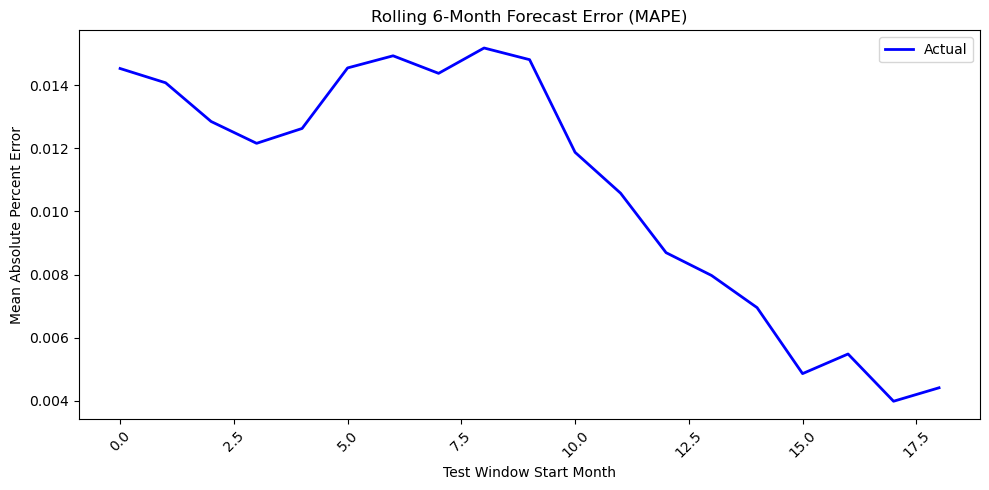

In [13]:
# Drop rows where MAE is NaN
plot_data = rolling_results_df.dropna(subset=['MAPE'])

plt.figure(figsize=(10, 5))
sns.lineplot(data=plot_data, x=plot_data.index, y='MAPE', label='Actual', linewidth=2, color='blue')

plt.xticks(rotation=45)
plt.title('Rolling 6-Month Forecast Error (MAPE)')
plt.xlabel('Test Window Start Month')
plt.ylabel('Mean Absolute Percent Error')
plt.tight_layout()
plt.show()

#### FORWARD FORECAST - ESTIMATE THE INPUTS AND BUILD THE FILE ####

In [14]:
# Define the forward forecast period and build the file
# Build the df based on the date range.  The months become the index
forecast_months = pd.date_range(forward_start_date, forward_end_date, freq="MS")
forward_df = pd.DataFrame(index=forecast_months)

# Fill in known inputs by defining the previous year values so we can estimate the YOY values for the forecast
# THis loop grabs last years value and then applies the growth rate to calculate the future input value
# date and prev_year are the outputs that are inserted into the formulas below
for date in forecast_months:
     prev_year = date - pd.DateOffset(years=1)  
    
     forward_df.loc[date, ind_1] = df.loc[prev_year, ind_1] * (1 + ind_label_1_dic[date] / 100)
     forward_df.loc[date, ind_2] = df.loc[prev_year, ind_2] * (1 + ind_label_2_dic[date] / 100)
     forward_df.loc[date, ind_3] = df.loc[prev_year, ind_3] * (1 + ind_label_3_dic[date] / 100)

# Initialize lag variable
last_known_value = df.loc[end_date, dep]
forward_df[ind_0] = np.nan
forward_df.loc[forecast_months[0], ind_0] = last_known_value

# Add empty columns for forecast and intervals
forward_df[ind_4] = 0
forward_df[ind_5] = 0
forward_df[dep] = np.nan
forward_df[f"{dep}_fcst"] = np.nan

# Pull the last 11 months of SE values (assumed to be Feb–Dec 2024)
start_date_ya = pd.Timestamp(forward_start_date) - pd.DateOffset(years=1) 
end_date_ya = pd.Timestamp(forward_end_date) - pd.DateOffset(years=1)
se_obs_values = df[f'{dep}_se_obs'].loc[start_date_ya:end_date_ya].copy()  

# Shift the index forward to 2025
se_obs_values.index = se_obs_values.index + pd.DateOffset(years=1)

# Assign these shifted SE values into forward_df
forward_df[f'{dep}_se_obs'] = se_obs_values

forward_df

,cpi_fah,rdi_adj,home_price,grocery_sales_lag1,covid1,covid2,grocery_sales,grocery_sales_fcst,grocery_sales_se_obs
2025-04-01,311.709258,17814.198,332.117010,76367.0,0,0,NaN,NaN,558.446945
2025-05-01,312.915075,17861.322,333.528420,NaN,0,0,NaN,NaN,557.917092
2025-06-01,314.066678,17865.912,333.496050,NaN,0,0,NaN,NaN,558.591761
2025-07-01,313.339904,17855.100,333.818925,NaN,0,0,NaN,NaN,558.508803
2025-08-01,313.588736,17844.492,331.629540,NaN,0,0,NaN,NaN,557.221249
2025-09-01,314.266623,17869.992,331.250100,NaN,0,0,NaN,NaN,558.043826


In [15]:
for col in forward_df.columns:
    print(col)

cpi_fah
rdi_adj
home_price
grocery_sales_lag1
covid1
covid2
grocery_sales
grocery_sales_fcst
grocery_sales_se_obs


In [16]:
sales_coef = {name: value for name, value in model.params.items()}
sales_coef

{'const': -11474.184334438625,
 'grocery_sales_lag1': 0.5486911683223605,
 'cpi_fah': 65.99815632880393,
 'rdi_adj': 1.1753189216120643,
 'home_price': 15.097651736545231,
 'covid1': -539.537198221924,
 'covid2': 684.7211043579973}

In [17]:
# Build the variable dictionary from sales_coef
coef_vars = {name: sales_coef[name] for name in coef_names}

# Initialize lists
forecasted_sales = []
lower_ci = []
upper_ci = []
lagged_sales = []

# Start with the most recent known value
last_sales = df[dep].iloc[-1]

# Loop through each row in forward_df
for i, row in forward_df.iterrows():
    # Start with the intercept
    y_hat = coef_vars['const']
    
    for var in ind:
        if var == ind_0:
            y_hat += coef_vars[var] * last_sales
        else:
            y_hat += coef_vars[var] * row[var]
    
    # Store forecast and confidence interval
    forecasted_sales.append(round(y_hat, 2))
    se = row[f'{dep}_se_obs']
    lower_ci.append(y_hat - 1.96 * se)
    upper_ci.append(y_hat + 1.96 * se)
    lagged_sales.append(last_sales)
    
    # Update lag for next iteration
    last_sales = y_hat

# Assign back to forward_df
forward_df[f'{dep}_fcst'] = forecasted_sales
forward_df['lower_bound'] = lower_ci
forward_df['upper_bound'] = upper_ci
forward_df[ind_0] = lagged_sales


In [18]:
# Stack the df and forward df
df_cols = df[forward_df.columns]
df_final = pd.concat([df_cols, forward_df], axis=0)
df_final

,cpi_fah,rdi_adj,home_price,grocery_sales_lag1,covid1,covid2,grocery_sales,grocery_sales_fcst,grocery_sales_se_obs,lower_bound,upper_bound
2007-01-01,195.918000,11956.600,182.718000,40153.000000,0,0,40253.0,40299.069887,566.783052,39188.175105,41409.964669
2007-02-01,197.735000,11996.000,182.471000,40253.000000,0,0,40646.0,40516.436099,565.488137,39408.079350,41624.792849
2007-03-01,198.816000,12035.100,182.193000,40646.000000,0,0,40572.0,40845.173558,564.605576,39738.546630,41951.800486
2007-04-01,199.250000,12052.800,182.131000,40572.000000,0,0,40416.0,40853.080702,564.303163,39747.046502,41959.114902
2007-05-01,200.237000,12059.900,181.885000,40416.000000,0,0,40740.0,40837.255802,563.898590,39732.014566,41942.497038
...,...,...,...,...,...,...,...,...,...,...,...
2025-05-01,312.915075,17861.322,333.528420,76951.501391,0,0,NaN,77428.490000,557.917092,76334.971046,78522.006046
2025-06-01,314.066678,17865.912,333.496050,77428.488546,0,0,NaN,77771.120000,558.591761,76676.276979,78865.956682
2025-07-01,313.339904,17855.100,333.818925,77771.116831,0,0,NaN,77903.320000,558.508803,76808.638086,78997.992593
2025-08-01,313.588736,17844.492,331.629540,77903.315339,0,0,NaN,77946.750000,557.221249,76854.597944,79038.905239


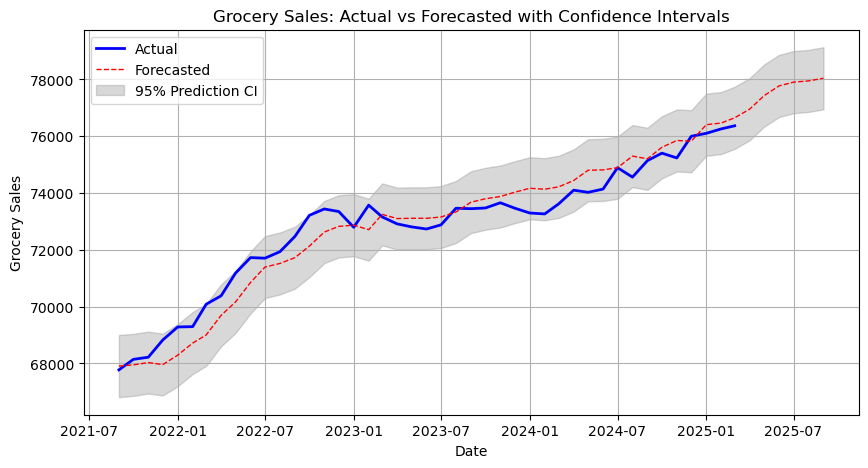

In [19]:
#Define the start and end date for filtering
start_date_chart = pd.Timestamp(forward_end_date) - pd.DateOffset(years=4) 
end_date_chart = forward_end_date

#Filter the DataFrame to only include the desired months
df_chart = df_final.loc[start_date_chart:end_date_chart]

#Plot the chart
plt.figure(figsize=(10, 5))

sns.lineplot(data=df_chart, x=df_chart.index, y=dep, label='Actual', color='blue', linewidth=2.0)
sns.lineplot(data=df_chart, x=df_chart.index, y=f'{dep}_fcst', label='Forecasted', color='red', linewidth=1.0, linestyle='dashed')

plt.fill_between(df_chart.index, df_chart['lower_bound'], df_chart['upper_bound'], color='grey', alpha=0.3, label="95% Prediction CI")

plt.xlabel('Date')
plt.ylabel(dep_label)
plt.title(f'{dep_label}: Actual vs Forecasted with Confidence Intervals')
plt.legend()
plt.grid(True)

plt.show()

In [20]:
print(df.index[0])
print(df.index[-1])

2007-01-01 00:00:00
2025-03-01 00:00:00


#### RESIDUAL BOOTSTRAP ####

In [49]:
# Convert to Timestamps if they aren't already
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter to training period only
train_df = df[(df.index >= start_date) & (df.index <= end_date)]
X_train = train_df[ind]
y_train = train_df[dep]

#TRAINING DATA MODEL Using 1000 trials
n_bootstraps = 2000
train_sim_matrix = []

model = LinearRegression()
model.fit(X_train, y_train)  # where X_train = train_df[ind]

# Predict once for baseline
y_pred_train = model.predict(X_train)
residuals = y_train - y_pred_train

print (y_pred_train.shape)

for b in range(n_bootstraps):
    y_sim = y_pred_train + np.random.choice(residuals, size=len(y_pred_train), replace=True)
    train_sim_matrix.append(y_sim)

train_sim_df = pd.DataFrame(train_sim_matrix, columns=X_train.index)

train_summary = train_sim_df.describe(percentiles=[0.025, 0.5, 0.975]).T
train_summary.columns = ['count', 'bs_mean', 'bs_std', 'bs_min', 'bs_2.5%', 'bs_median', 'bs_97.5%', 'bs_max']
train_summary

(219,)


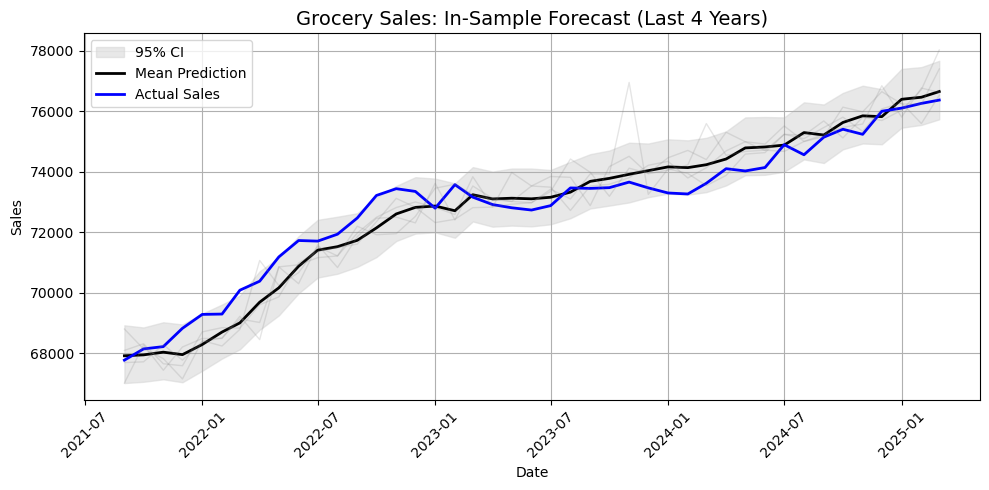

In [22]:
# Define start and end for plotting
start_date_chart = pd.Timestamp(forward_end_date) - pd.DateOffset(years=4)
end_date_chart = pd.Timestamp(forward_end_date)

# Filter training summary and actuals to just those dates
df_chart = train_summary.loc[start_date_chart:end_date_chart]
y_chart = y_train.loc[start_date_chart:end_date_chart]

# Filter simulation paths to match too
sim_df_chart = train_sim_df.loc[:, start_date_chart:end_date_chart]

# Plot
plt.figure(figsize=(10, 5))

# Confidence interval
plt.fill_between(df_chart.index, df_chart['bs_2.5%'], df_chart['bs_97.5%'],
                 color='lightgray', alpha=0.5, label='95% CI')

# Mean prediction
plt.plot(df_chart.index, df_chart['bs_mean'], color='black', linewidth=2, label='Mean Prediction')

# Actual sales
plt.plot(y_chart.index, y_chart.values, color='blue', linewidth=2, label='Actual Sales')

# Optional: sample paths
for i in range(0, 1000, 250):  # sample a few paths
    plt.plot(sim_df_chart.columns, sim_df_chart.iloc[i], color='gray', alpha=0.2, linewidth=1)

# Labels and formatting
plt.title("Grocery Sales: In-Sample Forecast (Last 4 Years)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### VALIDATE THE BOOTSTRAP TRAINING MODEL ####

In [23]:
# Make sure the index is datetime and sorted
df_validate = df.sort_index()

results = []

# Define unique months in the index
all_months = train_summary.index.unique()  # PeriodIndex for monthly grouping

# Define rolling parameters
n_periods = 24  # last 24 months
test_window = 6

for i in range(len(all_months) - n_periods, len(all_months) - test_window + 1):
    test_months = all_months[i:i + test_window]
    train_months = all_months[:i]

    train_df = df_validate[df_validate.index.isin(train_months)]
    test_df = df_validate[df_validate.index.isin(test_months)]
    
    # ✅ Define train and test features and targets
    X_train = train_df[ind]
    y_train = train_df[dep]

    X_test = test_df[ind]
    y_test = test_df[dep]
    
    # ✅ Fit model and predict
    validate = LinearRegression()
    validate.fit(X_train, y_train)
    forecast = validate.predict(X_test)

    mape = mean_absolute_percentage_error(y_test, forecast)
    
    results.append({
        'test_start': test_months[0],
        'test_end': test_months[-1],
        'MAPE': mape,
        'Actual': y_test.values,
        'Forecast': forecast
    })

# Turn results into a DataFrame
rolling_results_df = pd.DataFrame(results)

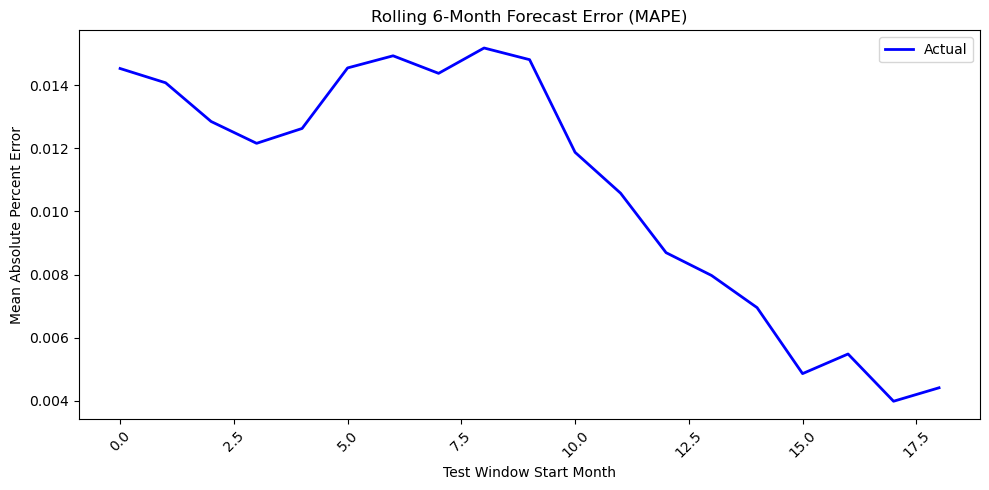

In [24]:
# Drop rows where MAE is NaN
plot_data = rolling_results_df.dropna(subset=['MAPE'])

plt.figure(figsize=(10, 5))
sns.lineplot(data=plot_data, x=plot_data.index, y='MAPE', label='Actual', linewidth=2, color='blue')

plt.xticks(rotation=45)
plt.title('Rolling 6-Month Forecast Error (MAPE)')
plt.xlabel('Test Window Start Month')
plt.ylabel('Mean Absolute Percent Error')
plt.tight_layout()
plt.show()

#### BOOTSTRAP FORWARD FCST ####

In [25]:
# Make sure X_future is ready and properly indexed
X_future = forward_df[ind].copy()
n_periods_forward = len(X_future)

# Initialize forecast simulation container
forecast_matrix = []

# Get last known sales value for recursive start
last_y = y_train.iloc[-1]

# Loop for bootstrapped forecast
for b in range(n_bootstraps):
    simulated_forecast = []
    last_sim_y = last_y

    for i in range(n_periods_forward):
        row = X_future.iloc[i].copy()

        # Inject the latest simulated lag value
        row['grocery_sales_lag1'] = last_sim_y
        row = row[ind]  # ensure column order
        row_df = pd.DataFrame([row])

        # Predict using trained model
        y_pred = model.predict(row_df)[0]

        # Add randomly sampled residual
        boot_resid = np.random.choice(residuals)
        y_sim = y_pred + boot_resid

        simulated_forecast.append(y_sim)
        last_sim_y = y_sim  # use this for next month’s lag

    forecast_matrix.append(simulated_forecast)


In [26]:
forecast_df = pd.DataFrame(forecast_matrix, columns=X_future.index)

forecast_summary = forecast_df.describe(percentiles=[0.025, 0.5, 0.975]).T
forecast_summary.columns = ['count', 'bs_mean', 'bs_std', 'bs_min', 'bs_2.5%', 'bs_median', 'bs_97.5%', 'bs_max']
forecast_summary

,count,bs_mean,bs_std,bs_min,bs_2.5%,bs_median,bs_97.5%,bs_max
2025-04-01,2000.0,76280.025980,505.166116,73072.590127,75407.023466,76272.449449,77271.114013,79352.152099
2025-05-01,2000.0,77051.679806,575.994845,73705.136511,76022.636802,77049.943719,78103.074044,80479.673334
2025-06-01,2000.0,77550.091951,622.424018,74069.116589,76424.260017,77551.218393,78703.607527,81166.289301
2025-07-01,2000.0,77791.956567,642.102524,74081.378854,76653.176155,77787.982598,79031.608155,81641.920870
2025-08-01,2000.0,77868.376931,668.509828,72800.375629,76646.457828,77890.366098,79045.960483,81006.354421
2025-09-01,2000.0,77997.997436,631.246840,74401.843802,76837.590338,77990.433885,79197.603283,81457.106605


In [27]:
# CONCAT TRAIN AND FORCAST DFs 
bs_df_final = pd.concat([train_summary, forecast_summary], axis=0)
bs_df_final

,count,bs_mean,bs_std,bs_min,bs_2.5%,bs_median,bs_97.5%,bs_max
2007-01-01,2000.0,40303.692367,565.527180,37093.402687,39405.774433,40282.884994,41291.926573,43372.964659
2007-02-01,2000.0,40522.385395,481.653587,37310.768899,39645.202238,40497.927072,41419.569103,43590.330871
2007-03-01,2000.0,40848.086402,516.998045,37639.506358,39952.502961,40826.664531,41838.030244,43919.068330
2007-04-01,2000.0,40833.747700,535.769006,37647.413502,39935.415862,40825.713618,41746.584600,43926.975474
2007-05-01,2000.0,40835.291203,511.625905,37631.588602,39944.585205,40818.746775,41830.112488,43911.150574
...,...,...,...,...,...,...,...,...
2025-05-01,2000.0,77051.679806,575.994845,73705.136511,76022.636802,77049.943719,78103.074044,80479.673334
2025-06-01,2000.0,77550.091951,622.424018,74069.116589,76424.260017,77551.218393,78703.607527,81166.289301
2025-07-01,2000.0,77791.956567,642.102524,74081.378854,76653.176155,77787.982598,79031.608155,81641.920870
2025-08-01,2000.0,77868.376931,668.509828,72800.375629,76646.457828,77890.366098,79045.960483,81006.354421


In [28]:
# MERGE BS WITH DF_FINAL
df_final = pd.merge(df_final, bs_df_final, left_index=True, right_index=True, how = 'inner')
df_final.to_csv('temp.csv')

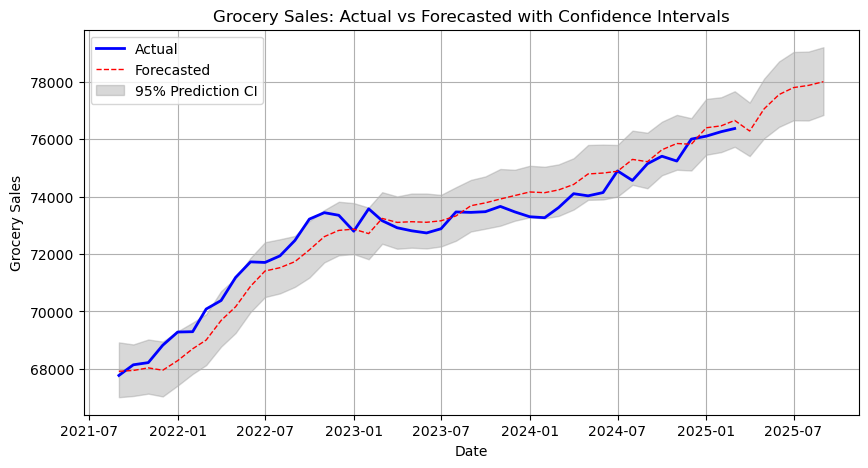

In [29]:
#Define the start and end date for filtering
start_date_chart = pd.Timestamp(forward_end_date) - pd.DateOffset(years=4) 
end_date_chart = forward_end_date

#Filter the DataFrame to only include the desired months
df_chart = df_final.loc[start_date_chart:end_date_chart]

# #Plot the chart
plt.figure(figsize=(10, 5))

sns.lineplot(data=df_chart, x=df_chart.index, y='grocery_sales', label='Actual', color='blue', linewidth=2.0)
sns.lineplot(data=df_chart, x=df_chart.index, y='bs_mean', label='Forecasted', color='red', linewidth=1.0, linestyle='dashed')
plt.fill_between(df_chart.index, df_chart['bs_2.5%'], df_chart['bs_97.5%'], color='grey', alpha=0.3, label="95% Prediction CI")

plt.xlabel('Date')
plt.ylabel(dep_label)
plt.title(f'{dep_label}: Actual vs Forecasted with Confidence Intervals')
plt.legend()
plt.grid(True)

plt.show()

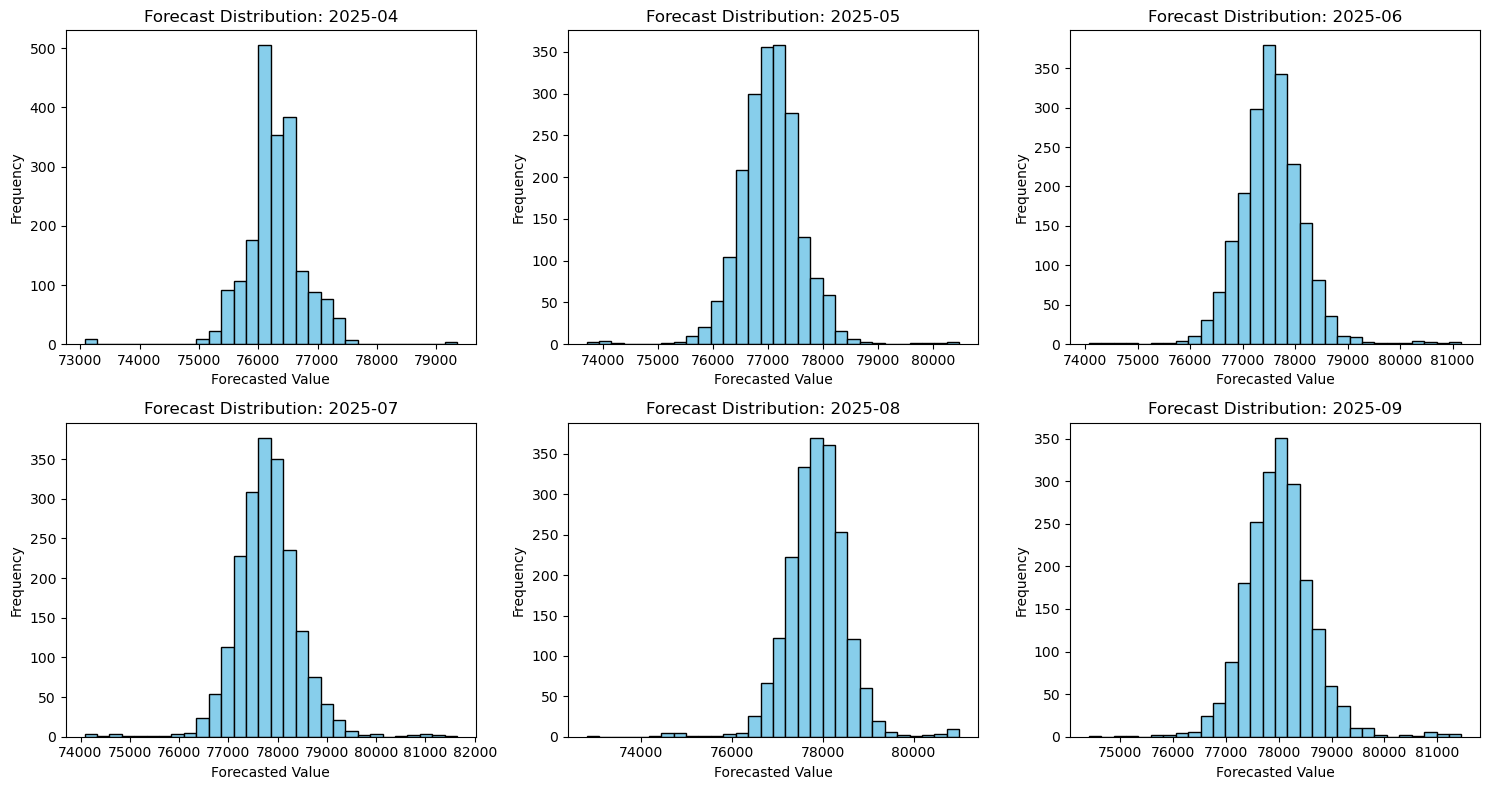

In [30]:
forecast_df = pd.DataFrame(forecast_matrix, columns=X_future.index)

# Plot histograms for each forecast period
n_periods = forecast_df.shape[1]
ncols = 3
nrows = (n_periods // ncols) + (n_periods % ncols > 0)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(forecast_df.columns):
    axes[i].hist(forecast_df[col], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f"Forecast Distribution: {col.strftime('%Y-%m')}")
    axes[i].set_xlabel("Forecasted Value")
    axes[i].set_ylabel("Frequency")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


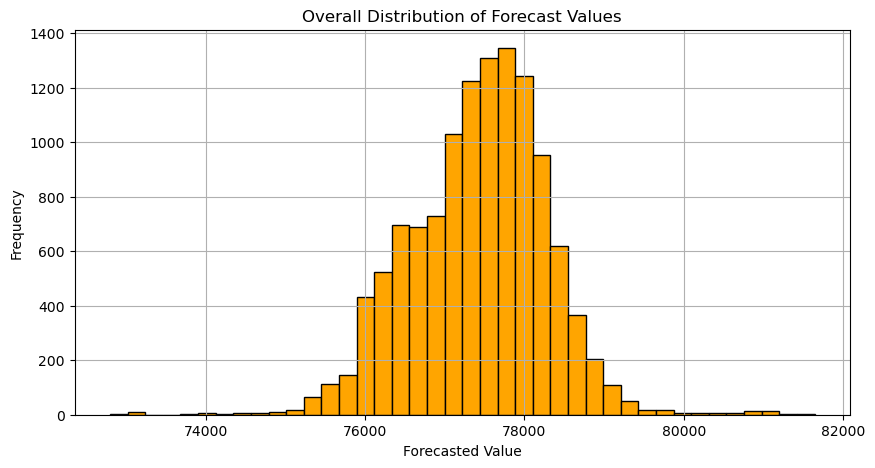

In [31]:
# Distribution across the 6 momth forecast
all_values = np.array(forecast_matrix).flatten()

plt.figure(figsize=(10, 5))
plt.hist(all_values, bins=40, color='orange', edgecolor='black')
plt.title("Overall Distribution of Forecast Values")
plt.xlabel("Forecasted Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [32]:
# shape: (n_bootstraps, n_forecast_months)
forecast_df = pd.DataFrame(forecast_matrix, columns=X_future.index)

In [33]:
# Get last year's date index for each forecast month
prior_year_index = forecast_df.columns - pd.DateOffset(years=1)

# Get actuals from y_train
y_train_series = y_train.copy()

# Align each forecast month with its prior year actual
y_last_year = y_train_series.reindex(prior_year_index)

# Broadcast these actuals into a DataFrame with shape (n_bootstraps, n_forecast_months)
y_last_year_matrix = pd.DataFrame([y_last_year.values] * n_bootstraps, columns=forecast_df.columns)


In [34]:
yoy_df = ((forecast_df - y_last_year_matrix) / y_last_year_matrix) * 100

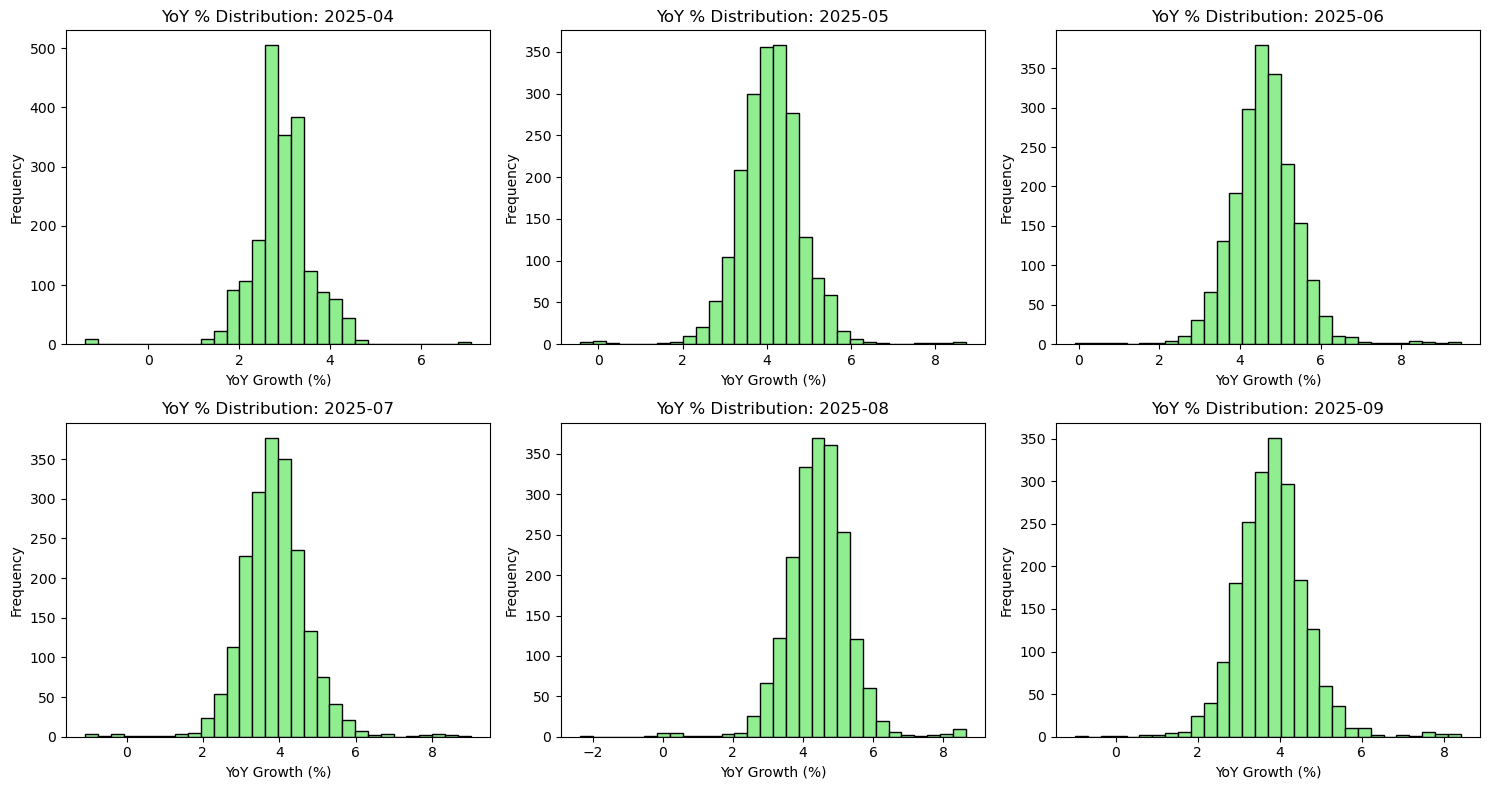

In [35]:
import matplotlib.pyplot as plt

n_periods = yoy_df.shape[1]
ncols = 3
nrows = (n_periods // ncols) + (n_periods % ncols > 0)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(yoy_df.columns):
    axes[i].hist(yoy_df[col], bins=30, color='lightgreen', edgecolor='black')
    axes[i].set_title(f"YoY % Distribution: {col.strftime('%Y-%m')}")
    axes[i].set_xlabel("YoY Growth (%)")
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


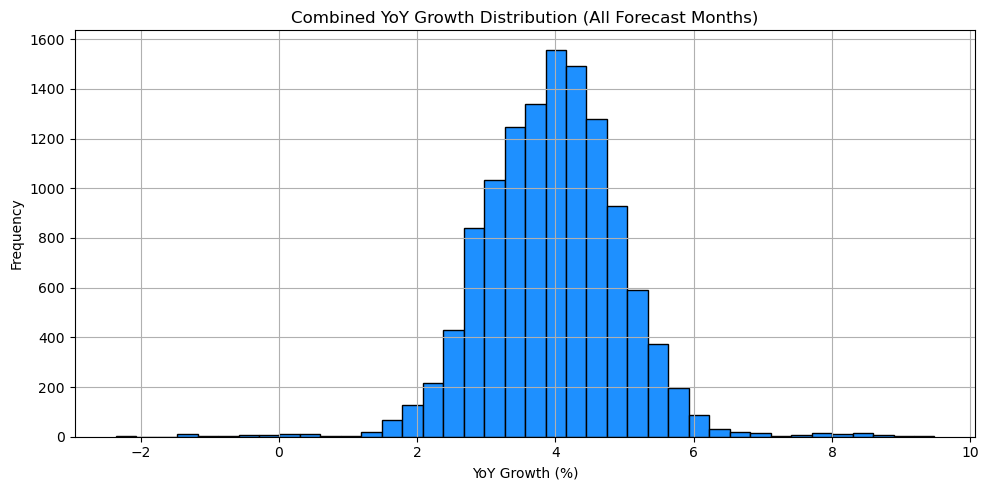

In [36]:
# Flatten the entire YoY DataFrame into one long array
all_yoy_values = yoy_df.values.flatten()

# Drop any NaNs that might be present (in case of missing prior-year actuals)
all_yoy_values = all_yoy_values[~np.isnan(all_yoy_values)]

# Plot histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(all_yoy_values, bins=40, color='dodgerblue', edgecolor='black')
plt.title("Combined YoY Growth Distribution (All Forecast Months)")
plt.xlabel("YoY Growth (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


#### CREATE THE FINAL REPORT ####

In [37]:
# Need to fill in forecasted values and then calculate expected YOY values

df_monthly = df_final.sort_index()
df_monthly.index = pd.to_datetime(df_monthly.index)

df_monthly[dep] = df_monthly[dep].fillna(df_monthly[f"{dep}_fcst"])

df_monthly["Actual YOY %"] = df_monthly[dep].pct_change(periods=12) * 100
df_monthly["OLS Forecast YOY %"] = df_monthly[f"{dep}_fcst"].pct_change(periods=12) * 100
df_monthly["Bootstrap Forecast YOY %"] = df_monthly["bs_mean"].pct_change(periods=12) * 100

df_monthly

,cpi_fah,rdi_adj,home_price,grocery_sales_lag1,covid1,covid2,grocery_sales,grocery_sales_fcst,grocery_sales_se_obs,lower_bound,...,bs_mean,bs_std,bs_min,bs_2.5%,bs_median,bs_97.5%,bs_max,Actual YOY %,OLS Forecast YOY %,Bootstrap Forecast YOY %
2007-01-01,195.918000,11956.600,182.718000,40153.000000,0,0,40253.00,40299.069887,566.783052,39188.175105,...,40303.692367,565.527180,37093.402687,39405.774433,40282.884994,41291.926573,43372.964659,NaN,NaN,NaN
2007-02-01,197.735000,11996.000,182.471000,40253.000000,0,0,40646.00,40516.436099,565.488137,39408.079350,...,40522.385395,481.653587,37310.768899,39645.202238,40497.927072,41419.569103,43590.330871,NaN,NaN,NaN
2007-03-01,198.816000,12035.100,182.193000,40646.000000,0,0,40572.00,40845.173558,564.605576,39738.546630,...,40848.086402,516.998045,37639.506358,39952.502961,40826.664531,41838.030244,43919.068330,NaN,NaN,NaN
2007-04-01,199.250000,12052.800,182.131000,40572.000000,0,0,40416.00,40853.080702,564.303163,39747.046502,...,40833.747700,535.769006,37647.413502,39935.415862,40825.713618,41746.584600,43926.975474,NaN,NaN,NaN
2007-05-01,200.237000,12059.900,181.885000,40416.000000,0,0,40740.00,40837.255802,563.898590,39732.014566,...,40835.291203,511.625905,37631.588602,39944.585205,40818.746775,41830.112488,43911.150574,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-01,312.915075,17861.322,333.528420,76951.501391,0,0,77428.49,77428.490000,557.917092,76334.971046,...,77051.679806,575.994845,73705.136511,76022.636802,77049.943719,78103.074044,80479.673334,4.599171,3.512148,3.029572
2025-06-01,314.066678,17865.912,333.496050,77428.488546,0,0,77771.12,77771.120000,558.591761,76676.276979,...,77550.091951,622.424018,74069.116589,76424.260017,77551.218393,78703.607527,81166.289301,4.900483,3.952891,3.652993
2025-07-01,313.339904,17855.100,333.818925,77771.116831,0,0,77903.32,77903.320000,558.508803,76808.638086,...,77791.956567,642.102524,74081.378854,76653.176155,77787.982598,79031.608155,81641.920870,4.020883,4.022593,3.890191
2025-08-01,313.588736,17844.492,331.629540,77903.315339,0,0,77946.75,77946.750000,557.221249,76854.597944,...,77868.376931,668.509828,72800.375629,76646.457828,77890.366098,79045.960483,81006.354421,4.543717,3.514950,3.421362


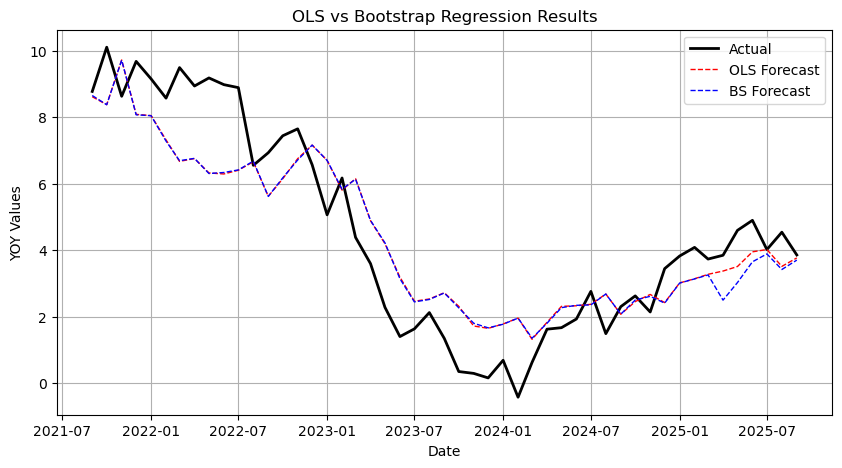

In [38]:
#Define the start and end date for filtering
start_date_chart = pd.Timestamp(forward_end_date) - pd.DateOffset(years=4) 
end_date_chart = forward_end_date

#Filter the DataFrame to only include the desired months
df_chart = df_monthly.loc[start_date_chart:end_date_chart]

# #Plot the chart
plt.figure(figsize=(10, 5))

sns.lineplot(data=df_chart, x=df_chart.index, y='Actual YOY %', label='Actual', color='black', linewidth=2.0)
sns.lineplot(data=df_chart, x=df_chart.index, y='OLS Forecast YOY %', label='OLS Forecast', color='red', linewidth=1.0, linestyle='dashed')
sns.lineplot(data=df_chart, x=df_chart.index, y='Bootstrap Forecast YOY %', label='BS Forecast', color='blue', linewidth=1.0, linestyle='dashed')

plt.xlabel('Date')
plt.ylabel('YOY Values')
plt.title('OLS vs Bootstrap Regression Results')
plt.legend()
plt.grid(True)

plt.show()

In [39]:
#Build a df to hold the forecasts

start = pd.to_datetime(forward_start_date)
end = pd.to_datetime(forward_end_date)
col_name = 'gsf_' + pd.to_datetime(forward_start_date).strftime('%Y_%m')

# Normalize both indexes to remove time component
new_fcst_mo = pd.date_range(start, end, freq='MS').normalize()
df_final.index = pd.to_datetime(df_final.index).normalize()
df_fcst_chart.index = pd.to_datetime(df_fcst_chart.index).normalize()

# Build the YA actual table
new_fcst = pd.DataFrame(index=new_fcst_mo)
new_fcst = pd.merge(new_fcst, df_final['grocery_sales_fcst'], left_index=True, right_index=True, how='inner')
new_fcst = new_fcst.rename(columns={'grocery_sales_fcst': col_name})

# Merge forecast table with new forecast
df_fcst_chart = pd.merge(df_fcst_chart, new_fcst, left_index=True, right_index=True, how='outer')
df_fcst_chart = pd.merge(df_fcst_chart, df_final['grocery_sales'], left_index=True, right_index=True, how='inner')

df_fcst_chart

,gsf_2025_02,gsf_2025_04,grocery_sales
2025-02-01,76577.66,NaN,76257.0
2025-03-01,76943.63,NaN,76367.0
2025-04-01,77315.87,76951.50,NaN
2025-05-01,77666.02,77428.49,NaN
2025-06-01,77983.98,77771.12,NaN
2025-07-01,78010.86,77903.32,NaN
2025-08-01,NaN,77946.75,NaN
2025-09-01,NaN,78039.57,NaN


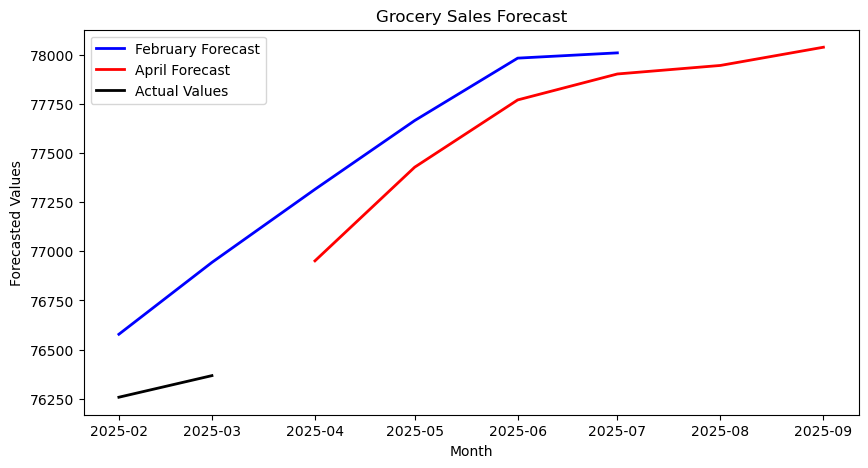

In [40]:
#Plot the chart
plt.figure(figsize=(10, 5))

sns.lineplot(data=df_fcst_chart, x=df_fcst_chart.index, y='gsf_2025_02', label='February Forecast', color='blue', linewidth=2.0)
sns.lineplot(data=df_fcst_chart, x=df_fcst_chart.index, y='gsf_2025_04', label='April Forecast', color='red', linewidth=2.0)
sns.lineplot(data=df_fcst_chart, x=df_fcst_chart.index, y='grocery_sales', label='Actual Values', color='black', linewidth=2.0)

plt.xlabel('Month')
plt.ylabel('Forecasted Values')
plt.title('Grocery Sales Forecast')
plt.legend()
plt.show()

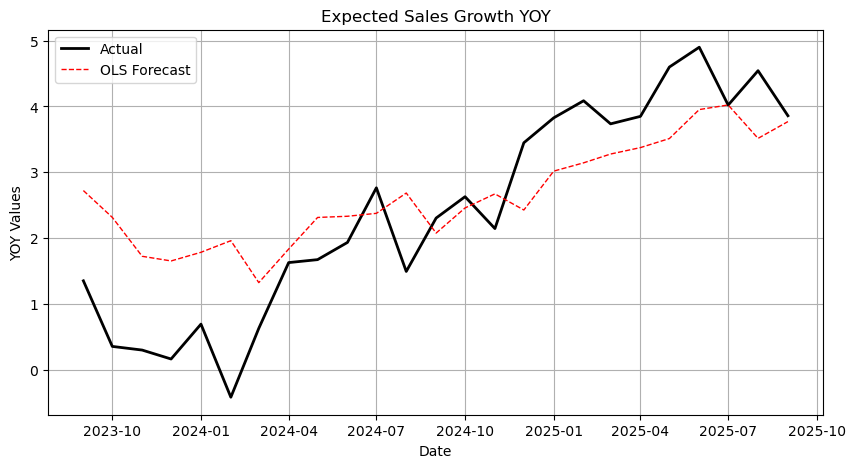

In [41]:
# BUILD THE YOY VIEW #
df_monthly['sales_yoy']=df_monthly['grocery_sales_fcst'] / df_monthly['grocery_sales_fcst'].shift(12) - 1

#Define the start and end date for filtering
start_date_chart = pd.Timestamp(forward_end_date) - pd.DateOffset(years=2) 
end_date_chart = forward_end_date

#Filter the DataFrame to only include the desired months
df_chart = df_monthly.loc[start_date_chart:end_date_chart]

# #Plot the chart
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_chart, x=df_chart.index, y='Actual YOY %', label='Actual', color='black', linewidth=2.0)
sns.lineplot(data=df_chart, x=df_chart.index, y='OLS Forecast YOY %', label='OLS Forecast', color='red', linewidth=1.0, linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('YOY Values')
plt.title('Expected Sales Growth YOY')
plt.legend()
plt.grid(True)

plt.show()

In [42]:
groc_sales_feb_ty = df_fcst_chart['gsf_2025_02'].sum()
groc_sales_apr_ty = df_fcst_chart['gsf_2025_04'].sum()

# Setup April Months
start_ty_feb = pd.to_datetime("2025-02-01")
end_ty_feb = pd.to_datetime("2025-07-01")
start_ly_feb = start_ty_feb - pd.DateOffset(months=12)
end_ly_feb = end_ty_feb - pd.DateOffset(months=12)

#Filter the DataFrame to only include the desired months
grocery_sales_feb_ly = df_monthly['grocery_sales'].loc[start_ly_feb:end_ly_feb].sum()
grocery_sales_feb_yoy = groc_sales_feb_ty/grocery_sales_feb_ly - 1
print(f"Grocery Sales YOY (Feb - Jul): {grocery_sales_feb_yoy: .1%}") 

# Setup April Months
start_ty_apr = pd.to_datetime("2025-04-01")
end_ty_apr = pd.to_datetime("2025-09-01")
start_ly_apr = start_ty_apr - pd.DateOffset(months=12)
end_ly_apr = end_ty_apr - pd.DateOffset(months=12)

#Filter the DataFrame to only include the desired months
grocery_sales_apr_ly = df_monthly['grocery_sales'].loc[start_ly_apr:end_ly_apr].sum()
grocery_sales_apr_yoy = groc_sales_apr_ty/grocery_sales_apr_ly - 1
print(f"Grocery Sales YOY (Apr - Sep): {grocery_sales_apr_yoy: .1%}") 

Grocery Sales YOY (Feb - Jul):  4.6%
Grocery Sales YOY (Apr - Sep):  4.3%


In [43]:
df_fcst_chart.to_csv('grocery_forecast_chart.csv')

In [44]:
df_monthly.to_csv('grocery_forecast_month.csv')